In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Load Data

In [31]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

## Data Exploration

In [32]:
print(len(train_df))
train_df.head()

891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [33]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [34]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Feature Engineering

In [35]:
def extract_features(df):
    df = df.copy()
    df['FamCnt'] = df['SibSp'] + df['Parch']
    df['IsAlone'] = (df['FamCnt'] == 0).astype(int)
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col','Don', 'Dr', 
                                       'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['CabinLetter'] = df['Cabin'].astype(str).str[0]
    return df

In [36]:
train_df = extract_features(train_df)
test_df = extract_features(test_df)

In [37]:
y = train_df['Survived']
train_df.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_passenger_ids = test_df['PassengerId']
test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [38]:
combined = pd.concat([train_df, test_df], axis=0, sort=False)
combined = pd.get_dummies(combined, columns=['Sex', 'Embarked', 'Pclass', 'Title', 'CabinLetter'])
combined.fillna(combined.median(numeric_only=True), inplace=True)

X = combined.iloc[:len(y)]
X_test = combined.iloc[len(y):]

## Train/Validation Split

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Comparison

In [40]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(verbose=-1, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    roc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
    report = classification_report(y_val, preds)
    results[name] = {
        "accuracy": acc,
        "roc_auc": roc,
        "report": report
    }

## Model Selection

In [41]:
summary = pd.DataFrame({k: {"accuracy": v["accuracy"], "roc_auc": v["roc_auc"]} for k, v in results.items()})
print("\nModel Accuracy and ROC AUC Summary:\n")
print(summary)


Model Accuracy and ROC AUC Summary:

          Logistic Regression  Random Forest  Gradient Boosting   XGBoost  \
accuracy             0.815642       0.810056           0.815642  0.815642   
roc_auc              0.882111       0.893629           0.885779  0.885972   

          LightGBM  
accuracy  0.793296  
roc_auc   0.893436  


Taking ROC AUC into accout LightGBM is the most suited model

## LightGMB Fine-Tuning

In [42]:
# RandomizedSearchCV for LightGBM
param_dist_lgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'max_depth': [5, 10, -1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

lgb_model = lgb.LGBMClassifier(verbose=-1, random_state=42)
random_search_lgb = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist_lgb,
                                       n_iter=10, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
random_search_lgb.fit(X_train, y_train)
print("Best Parameters for LightGBM:", random_search_lgb.best_params_)

best_lgb_model = random_search_lgb.best_estimator_
lgb_preds = best_lgb_model.predict(X_val)
lgb_acc = accuracy_score(y_val, lgb_preds)
lgb_roc = roc_auc_score(y_val, best_lgb_model.predict_proba(X_val)[:, 1])
lgb_report = classification_report(y_val, lgb_preds)
print("\nLightGBM Test Accuracy:", lgb_acc)
print("ROC AUC:", lgb_roc)
print("Classification Report:\n", lgb_report)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for LightGBM: {'subsample': 0.8, 'num_leaves': 70, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

LightGBM Test Accuracy: 0.8100558659217877
ROC AUC: 0.8846203346203346
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



## Plot ROC AUC

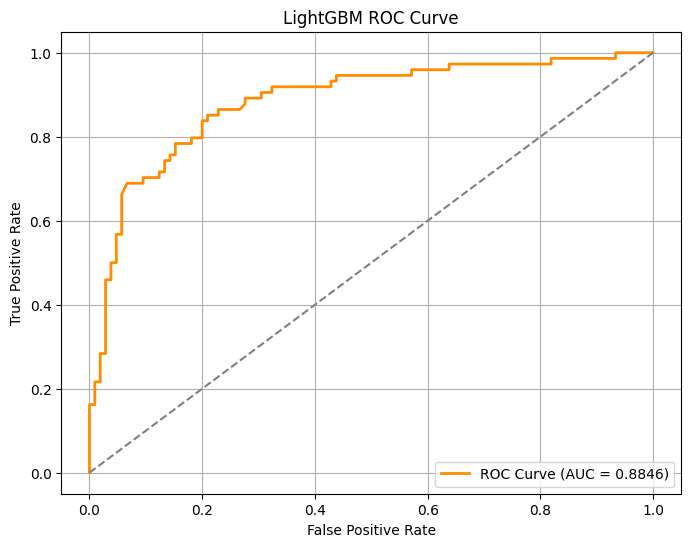

In [45]:
# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_val, best_lgb_model.predict_proba(X_val)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="darkorange", lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LightGBM ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Submission

In [46]:
best_model = best_lgb_model
best_model.fit(X, y)
preds = best_model.predict(X_test)
submission = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": preds
})
submission.to_csv("submission.csv", index=False)
print("Submission saved to submission.csv")

Submission saved to submission.csv


In [47]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
